# 29 · Flujo óptico disperso con Lucas–Kanade

## Formulación local de Lucas–Kanade

Sea $I(x,y,t)$ la intensidad de imagen y $\mathbf{w} = (u,v)^\top$ el vector de flujo en una vecindad $\Omega$ alrededor de $(x,y)$. Para cada píxel $(x_i,y_i) \in \Omega$ se escribe la ecuación de flujo óptico

$I_x(x_i,y_i) u + I_y(x_i,y_i) v + I_t(x_i,y_i) = 0$

En forma matricial:

$A \mathbf{w} = \mathbf{b}$

con

$A = \begin{bmatrix} I_x(x_1,y_1) & I_y(x_1,y_1) \\ \vdots & \vdots \\ I_x(x_n,y_n) & I_y(x_n,y_n) \end{bmatrix}, \quad \mathbf{w} = \begin{bmatrix} u \\ v \end{bmatrix}, \quad \mathbf{b} = -\begin{bmatrix} I_t(x_1,y_1) \\ \vdots \\ I_t(x_n,y_n) \end{bmatrix}$

La solución de mínimos cuadrados es

$\mathbf{w} = (A^\top A)^{-1} A^\top \mathbf{b}$

Para que la solución sea estable se requiere que la matriz $A^\top A$ sea bien condicionada, lo que implica autovalores suficientemente grandes en ambas direcciones, condición que se cumple en esquinas o puntos de alto gradiente bidireccional.

## Selección de puntos de interés y seguimiento disperso

Se utiliza un detector de esquinas o puntos de interés para seleccionar un conjunto de posiciones iniciales $\{(x_j,y_j)\}$ y se aplica Lucas–Kanade piramidal para estimar el desplazamiento de estos puntos entre cuadros consecutivos de un video.

Imports y ruta del video.

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

VIDEO_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\coches.mp4"

Detección de puntos de interés en el primer frame mediante `goodFeaturesToTrack`.

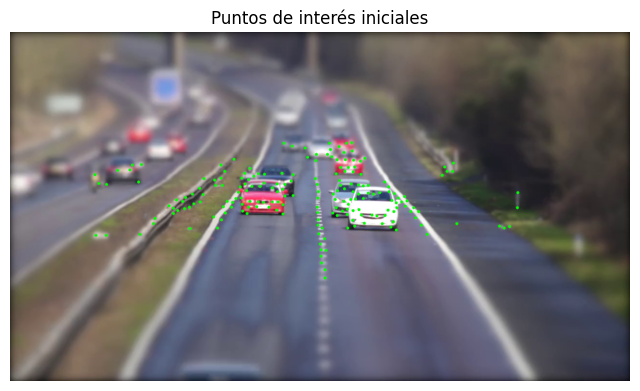

In [ ]:
cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame0 = cap.read()
if not ret:
    cap.release()
    raise RuntimeError("No se pudo leer el primer frame del video.")

gray0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)

feature_params = dict(maxCorners=200,
                      qualityLevel=0.01,
                      minDistance=10,
                      blockSize=7,
                      useHarrisDetector=False)

p0 = cv2.goodFeaturesToTrack(gray0, mask=None, **feature_params)

rgb0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)
vis0 = rgb0.copy()
if p0 is not None:
    for x,y in np.float32(p0).reshape(-1,2):
        cv2.circle(vis0, (int(x),int(y)), 3, (0,255,0), -1)

plt.figure(figsize=(8,6))
plt.imshow(vis0)
plt.title("Puntos de interés iniciales")
plt.axis("off")
plt.show()

Seguimiento de los puntos mediante flujo óptico disperso de Lucas–Kanade piramidal.

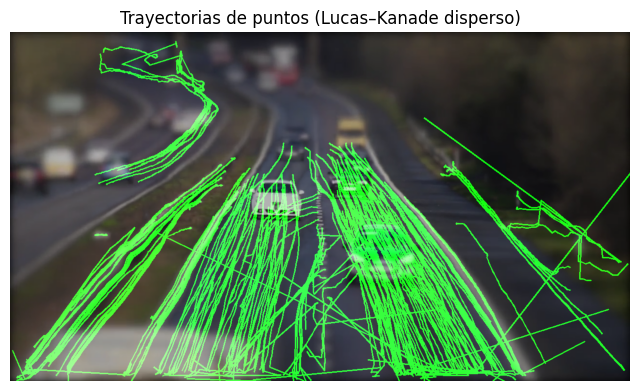

In [17]:
lk_params = dict(winSize=(21,21),
                 maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

old_gray = gray0.copy()
old_points = p0

mask_tracks = np.zeros_like(frame0)
last_valid_frame = frame0.copy()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    last_valid_frame = frame.copy()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if old_points is None or len(old_points) == 0:
        break

    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray, old_points, None, **lk_params)
    if p1 is None:
        break

    st = st.reshape(-1)
    good_new = p1[st==1]
    good_old = old_points[st==1]

    if good_new.shape[0] == 0 or good_old.shape[0] == 0:
        break

    good_new = good_new.reshape(-1, 2)
    good_old = good_old.reshape(-1, 2)

    for (x_new,y_new),(x_old,y_old) in zip(good_new, good_old):
        x_new, y_new = int(x_new), int(y_new)
        x_old, y_old = int(x_old), int(y_old)
        cv2.line(mask_tracks, (x_new,y_new), (x_old,y_old), (0,255,0), 2)

    old_gray = gray.copy()
    old_points = good_new.reshape(-1,1,2)

cap.release()

rgb_last = cv2.cvtColor(last_valid_frame, cv2.COLOR_BGR2RGB)
tracks_rgb = cv2.cvtColor(mask_tracks, cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted(rgb_last, 0.7, tracks_rgb, 0.9, 0)

plt.figure(figsize=(8,6))
plt.imshow(overlay)
plt.title("Trayectorias de puntos (Lucas–Kanade disperso)")
plt.axis("off")
plt.show()